## Importing librairies

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
warnings.simplefilter(action='ignore')
%matplotlib inline

In [2]:
df = pd.read_csv('ML_RDY_SALARY.csv')
df['Dept'] = df['Dept'].astype(int)

## Features correlation

(30.5, -0.5)

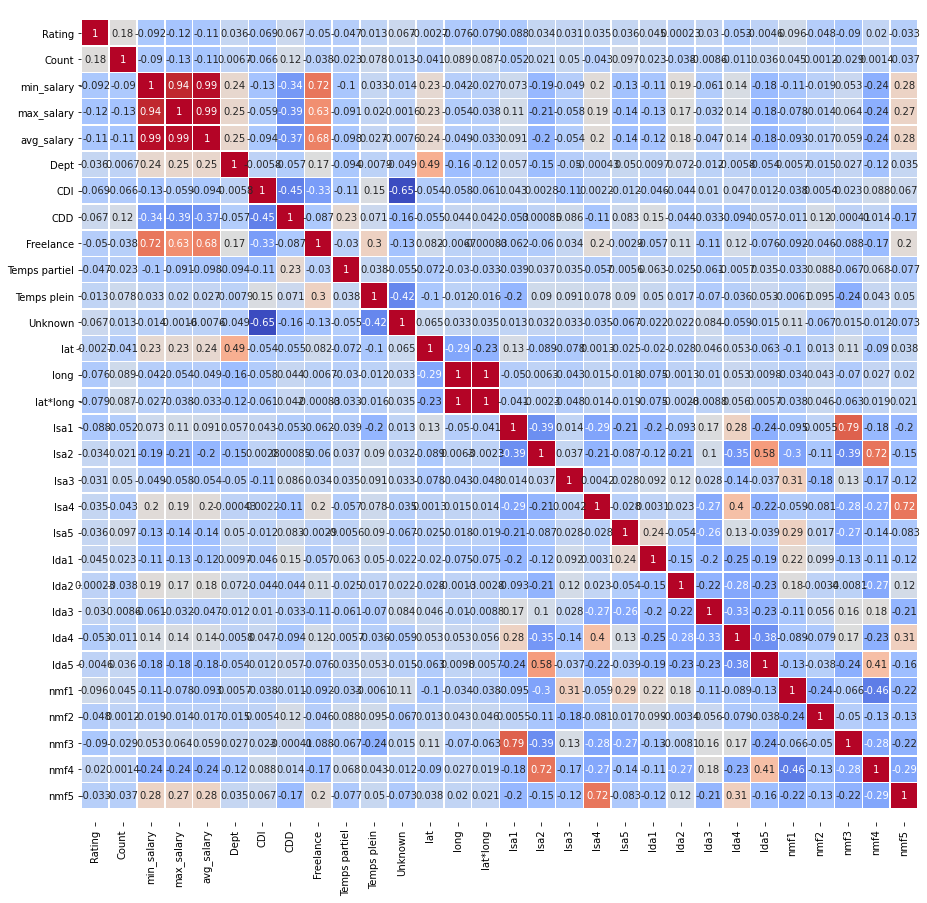

In [3]:
corr = df.corr()
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(data=corr, annot=True, linewidths=.5, cmap='coolwarm', cbar=False, ax=ax)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

There is some multicolinearity between LSA and LDA features wich is obvious because they are both similar algorithms based on main topics from Job title feature. For linear models, we should be carefull about this : using lsa OR lda features depending on which work best.

Target is especially linearly correlated to :
- nmf5 : 0.29
- nmf4 : -0.25
- lsa4 : 0.22
- latitude : 0.22
- freelance : 0.68
- cdd : -0.38

Those may be good linear predictors.

# -------------------Modeling / Machine Learning -------------------

# <font color='red'> Regression </font>


- Some linear algorithms are very sensitive to outliers thats why we are using a median based scaler and we remove them from the target based on tukey method
- We also apply log transformation to the target since its distribution is skewed
- We use Box Cox transformation to treat highly skewed variables

In [4]:
df_salary = df
df_salary.columns

Index(['Title', 'Location', 'Date', 'Company', 'Rating', 'Count', 'Contract', 'Description', 'min_salary', 'max_salary', 'avg_salary', 'Dept', 'title_words', 'summary_words', 'contractWords', 'CDI', 'CDD', 'Freelance', 'Temps partiel', 'Temps plein', 'Unknown', 'geocode', 'lat-long', 'lat', 'long', 'lat*long', 'Regions', 'BagOfWords', 'lsa1', 'lsa2', 'lsa3', 'lsa4', 'lsa5', 'lda1', 'lda2', 'lda3', 'lda4', 'lda5', 'nmf1', 'nmf2', 'nmf3', 'nmf4', 'nmf5'], dtype='object')

### Box Cox

In [5]:
from scipy.stats import norm, skew

numeric_feats = df_salary[['Rating', 'Count', 'Dept', 'lat', 'long', 'lat*long', 'lsa1', 'lsa2', 'lsa3',
                          'lsa4', 'lsa5', 'lda1', 'lda2', 'lda3', 'lda4', 'lda5', 'nmf1', 'nmf2', 
                          'nmf3', 'nmf4', 'nmf5']]

# Check the skew of all numerical features
skewed_feats = numeric_feats.apply(
    lambda x: skew(x.dropna())).sort_values(ascending=False)

skewness = pd.DataFrame({'Skew': skewed_feats})
skewness.head(10)

,Skew
Count,6.962391
nmf2,5.164066
Rating,2.357536
lda1,2.257977
lda2,1.846955
lsa4,1.703259
lda3,1.666365
nmf5,1.535657
nmf3,1.369993
lda5,1.334082


In [6]:
from scipy.special import boxcox1p

skewness = skewness[abs(skewness) > 0.75]
skewed_features = skewness.index

lam = 0.15
for feat in skewed_features:
    df_salary[feat] = boxcox1p(df_salary[feat], lam)
df_salary.dropna(inplace=True)

Getting our predictors and target. Here lda and lsa are features extracted thanks to NLP techniques from Title and Description columns. Note that this is for regression for now since we took the 'avg_salary' column as y which is continuous.

As a reminder, lsa features are based on the LSA algorithm and describe each job offer based on 5 main topics present in the whole corpus (here Job title). nmf features are based on the NMF algorithm, but this time they represent 5 main topics from the Job description corpus. 

Because of computational limitations, we were unable to use LSA on the Job description.

In [7]:
X = df_salary[['Rating', 'CDI', 'CDD', 'Freelance', 'Temps partiel', 'Temps plein', 'Unknown',
               'Count', 'Dept', 'lat', 'lat*long', 'long', 'lsa1', 'lsa2', 'lsa3', 'lsa4', 'lsa5',
               'nmf1', 'nmf2', 'nmf3', 'nmf4', 'nmf5']]
y = df_salary['avg_salary']

### Features selection 

In [8]:
# creating set to hold the correlated features
corr_features = set()

# create the correlation matrix (default to pearson)
corr_matrix = X.corr()

for i in range(len(corr_matrix .columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.5:
            colname = corr_matrix.columns[i]
            corr_features.add(colname)
            
X.drop(labels=corr_features, axis=1, inplace=True)
print(f'Highly correlated features to be removed : {corr_features}')

Highly correlated features to be removed : {'Count', 'nmf5', 'Unknown', 'nmf3', 'long', 'nmf4'}


Spearman correlation coefficient (rank based) shows non lieanr relationship between features. We also performed it and it removes exactly the same features as Pearson.

### Target transformation and scaling of features

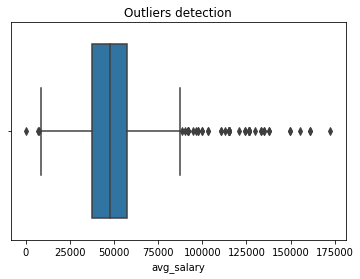

In [9]:
sns.boxplot(y)
plt.title('Outliers detection');

We clearly have outliers in our target, this can damage predicting capabilities for linear models, we decide to treat them using Tukey method (here it's a soften method : 0.2/0.8 percentiles)

In [10]:
from numpy import percentile

q25, q75 = percentile(y, 20), percentile(y, 80)
iqr = q75 - q25

cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off

# identify outliers
outliers = [x for x in y if x < lower or x > upper]
len(outliers)

39

(634, 16)
(634,)


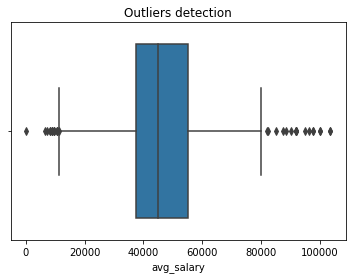

In [11]:
# remove outliers
X = X[~(y.isin(outliers))]
y = y[~(y.isin(outliers))]
print(X.shape)
print(y.shape)

sns.boxplot(y)
plt.title('Outliers detection');

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

In [13]:
# median scaling of features
from sklearn.preprocessing import RobustScaler

transformer = RobustScaler().fit(X_train)
X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)

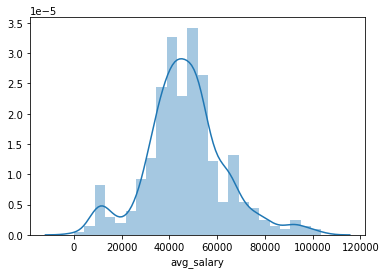

In [14]:
#normality check for the target
ax = sns.distplot(y_train)
plt.show()

Here, after the outliers removal from the target, there is not much point to use any transformation since the distribution is close to normal already

In [15]:
# regression evaluation function
from sklearn.metrics import mean_squared_error, mean_squared_error, mean_absolute_error, median_absolute_error

def evaluate(y_test, y_pred):

    print('Model Performance')
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f'RMSE: {rmse}')
    print('Mean Squared Error      = ',
          mean_squared_error(y_test, y_pred))
    print('Root Mean Square Error = ', np.sqrt(
        mean_squared_error(y_test, y_pred)))
    print('Mean Absolute Error    = ',
          mean_absolute_error(y_test, y_pred))
    print('Median Absolute Error  = ',
          median_absolute_error(y_test, y_pred))

## Random forest

In [16]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor

rf_regressor = RandomForestRegressor(random_state = 42)

In [17]:
random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)],
               'max_depth': [int(x) for x in np.linspace(60, 120, num = 6)],
               'min_samples_split': [1, 2, 5],
               'min_samples_leaf': [1, 2, 4]}

In [18]:
rf_random = RandomizedSearchCV(estimator=rf_regressor, param_distributions=random_grid,
                               n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   55.9s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [19]:
random_rf = rf_random.best_estimator_
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_depth': 60}

In [20]:
y_pred2 = rf_random.best_estimator_.predict(X_test)
# y_pred2 = np.exp(y_pred2) 

In [21]:
evaluate(y_test, y_pred2)

Model Performance
RMSE: 11350.412980444165
Mean Squared Error      =  128831874.82663539
Root Mean Square Error =  11350.412980444165
Mean Absolute Error    =  8266.242652685145
Median Absolute Error  =  5553.441273733188


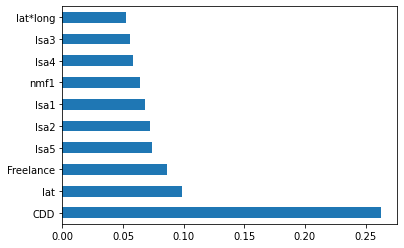

In [22]:
importances = rf_random.best_estimator_.feature_importances_
feat_importances = pd.Series(importances, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh');

Trying to improve results using more hyperparameters combinations

In [23]:
param_grid = {
    'max_depth': [50, 80, 110, 140],
    'max_features': [int(x) for x in np.linspace(2, len(X.columns), num=10)],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 4, 6, 8],
    'n_estimators': [200, 400, 600]}

grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, scoring='neg_root_mean_squared_error',
                           cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 1440 candidates, totalling 4320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   59.4s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 4320 out of 4320 | elapsed: 11.5min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

In [24]:
y_pred3 = grid_search.best_estimator_.predict(X_test)
# y_pred3 = np.exp(y_pred3) 

In [25]:
evaluate(y_test, y_pred3)

Model Performance
RMSE: 11475.957291687848
Mean Squared Error      =  131697595.76064347
Root Mean Square Error =  11475.957291687848
Mean Absolute Error    =  8242.140099580713
Median Absolute Error  =  5546.610000000001


Surprisingly enough, the model from randomized search was better, RMSE wise.

## Boosted trees

In [26]:
param_grid = {'eta': [0.1, 0.2, 0.3], 'min_child_weight': [1, 2, 4], 'max_depth': [1, 3, 5, 10], 
              'gamma': [0.001, 0.05, 0.1, 0.5], 'subsample': [0.3, 0.5, 0.7], 'n_estimators' :[1600, 2000, 2400]}

In [27]:
import xgboost as xgb

grid_xgb = GridSearchCV(xgb.XGBRegressor(seed=42, booster='gbtree'), param_grid=param_grid, 
                        scoring='neg_root_mean_squared_error',
                        n_jobs=-1, refit=True, cv=3, verbose=1)
grid_xgb.fit(X_train, y_train)

Fitting 3 folds for each of 1296 candidates, totalling 3888 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 3888 out of 3888 | elapsed: 12.3min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_es...
                                    seed=42, subsample=None, tree_method=None,
                                    validate_parameters=False, verbosity=None),
             iid='deprecated', n_jobs=-1,
             param_grid={'eta': [0.1, 0.2, 0.3],
                         'gamma': [0.001, 

In [28]:
y_pred4 = grid_xgb.best_estimator_.predict(X_test)
# y_pred4 = np.exp(y_pred4) 

In [29]:
evaluate(y_test, y_pred4)

Model Performance
RMSE: 12194.405077507534
Mean Squared Error      =  148703515.19434154
Root Mean Square Error =  12194.405077507534
Mean Absolute Error    =  8693.217054834906
Median Absolute Error  =  6163.1328125


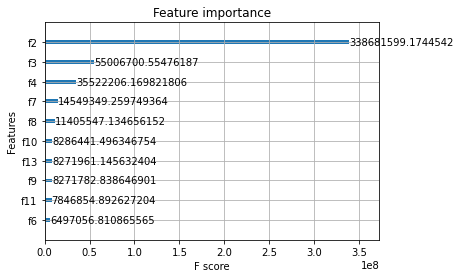

In [30]:
xgb.plot_importance(grid_xgb.best_estimator_, importance_type='gain', max_num_features=10)
plt.rcParams['figure.figsize'] = [10, 10]
plt.show();

Here the NLP features derivated from Description and Job title are good predictors.

In [31]:
best_xgb = grid_xgb.best_estimator_

## More linear and tree based models

All models here have built-in features selection techniques

In [32]:
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Lasso, ElasticNet

lasso = Lasso(alpha=0.0005, random_state=1)

el_net = ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3)

kernel_r = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

lgb = lgb.LGBMRegressor(objective='regression', num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin=55, bagging_fraction=0.8,
                              bagging_freq=5, feature_fraction=0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf=6, min_sum_hessian_in_leaf=11)

gboost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [33]:
lasso.fit(X_train, y_train)
el_net.fit(X_train, y_train)
kernel_r.fit(X_train, y_train)
lgb.fit(X_train, y_train)
gboost.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.05, loss='huber',
                          max_depth=4, max_features='sqrt', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=15, min_samples_split=10,
                          min_weight_fraction_leaf=0.0, n_estimators=3000,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=5, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [34]:
y_pred_lasso = lasso.predict(X_test)
# y_pred_lasso = np.exp(y_pred_lasso)

y_pred_el_net = el_net.predict(X_test)
# y_pred_el_net = np.exp(y_pred_el_net)

y_pred_kernel_r = kernel_r.predict(X_test)
# y_pred_kernel_r = np.exp(y_pred_kernel_r)

y_pred_lgb = lgb.predict(X_test)
# y_pred_lgb = np.exp(y_pred_lgb)

y_pred_gboost = gboost.predict(X_test)
# y_pred_gboost = np.exp(y_pred_gboost)

In [35]:
evaluate(y_test, y_pred_lasso)

Model Performance
RMSE: 12623.20175775714
Mean Squared Error      =  159345222.61704296
Root Mean Square Error =  12623.20175775714
Mean Absolute Error    =  9200.720877660266
Median Absolute Error  =  6468.7196757411875


In [36]:
evaluate(y_test, y_pred_el_net)

Model Performance
RMSE: 12622.590097047629
Mean Squared Error      =  159329780.75808486
Root Mean Square Error =  12622.590097047629
Mean Absolute Error    =  9200.67327291895
Median Absolute Error  =  6472.235502583928


In [37]:
evaluate(y_test, y_pred_kernel_r)

Model Performance
RMSE: 12027.625186656633
Mean Squared Error      =  144663767.630697
Root Mean Square Error =  12027.625186656633
Mean Absolute Error    =  8626.474629573366
Median Absolute Error  =  5651.413840248948


In [38]:
evaluate(y_test, y_pred_lgb)

Model Performance
RMSE: 12300.436320055736
Mean Squared Error      =  151300733.66374633
Root Mean Square Error =  12300.436320055736
Mean Absolute Error    =  9272.665479160774
Median Absolute Error  =  7602.4445328696165


In [39]:
evaluate(y_test, y_pred_gboost)

Model Performance
RMSE: 11974.292263330928
Mean Squared Error      =  143383675.2076669
Root Mean Square Error =  11974.292263330928
Mean Absolute Error    =  8918.245141737742
Median Absolute Error  =  7152.781618905523


From those results it seems hard to go below 12k RMSE. Kernel ridge seems to be the only model really powerfull at minimizing the MAE.

## Simple averaging of some of those models

In [40]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

In [41]:
class Averaging(BaseEstimator, RegressorMixin, TransformerMixin):
    
    def __init__(self, models):
        self.models = models
        
    # clones of original models to fit the data
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        for model in self.models_:
            model.fit(X, y)

        return self
    
    # predictions for cloned models and averaging
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [42]:
averaged = Averaging(models = (random_rf, best_xgb, gboost, el_net, kernel_r))

In [43]:
averaged.fit(X_train, y_train)
y_pred_averaged = averaged.predict(X_test)
# y_pred_averaged = np.exp(y_pred_averaged)

In [44]:
evaluate(y_test, y_pred_averaged)

Model Performance
RMSE: 11316.455580024742
Mean Squared Error      =  128062166.89467311
Root Mean Square Error =  11316.455580024742
Mean Absolute Error    =  8041.8871270521695
Median Absolute Error  =  5012.883017658503


In [45]:
import pickle
filename = 'averaged_regression.sav'
pickle.dump(averaged, open(filename, 'wb'))

Our best score so far (RMSE wise), but still, a salary prediction 11.3k far from the mean doesn't seem reasonable. On the other hand, MAE is around 5k which is quite satisfying. We could probably make a more sophisticated ensembling algorithm.

Let's make it a classification problem. 

## <font color='red'> Classification </font>

## First baselines

Setting our binary target : 
 - salary above the median
 - salary below the median

### Filtering features 

As a reminder, here our highly skewed numeric features have been through Box Cox transformation.

In [46]:
X = df_salary[['Rating', 'Count', 'CDI', 'CDD', 'Freelance', 'Temps partiel',
        'Temps plein', 'Unknown', 'lat', 'long', 'lat*long', 'lsa1', 'lsa2', 'lsa3', 'lsa4', 'lsa5', 'lda1',
        'lda2', 'lda3', 'lda4', 'lda5', 'nmf1', 'nmf2', 'nmf3', 'nmf4', 'nmf5']]
y = df_salary['avg_salary']

In [47]:
y = pd.qcut(y, 2, labels=False) 

Creating dummy variables from Dept

In [48]:
dept = pd.get_dummies(df['Dept'], drop_first=True)

In [49]:
X = pd.concat([X, dept], axis=1)

### Spliting and scaling

In [50]:
from sklearn.model_selection import train_test_split

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X, y, test_size=0.25, random_state=42)

In [51]:
from sklearn.preprocessing import RobustScaler

transformer = RobustScaler().fit(X_train_clf)
X_train_clf = transformer.transform(X_train_clf)
X_test_clf = transformer.transform(X_test_clf)

Using RFECV algorithms to remove uninformative predictors : it works by training the model, evaluating it, then removing the least significant feature, and repeating.

In [52]:
# from sklearn.feature_selection import RFECV

# mod = RandomForestClassifier(random_state=42)
# selector = RFECV(mod, scoring='accuracy', n_jobs=-1, cv=3)
# selector = selector.fit(X_train_clf, y_train_clf)

In [53]:
# print("Optimal number of features : %d" % selector.n_features_)

# # Plot number of features VS. cross-validation scores
# plt.figure()
# plt.xlabel("Number of features selected")
# plt.ylabel("Cross validation score (nb of correct classifications)")
# plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
# plt.show()

In [54]:
# X_train_clf = X_train_clf[:, selector.support_]
# X_test_clf = X_test_clf[:, selector.support_]

In [55]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

lr = LogisticRegression(random_state=42)
lr.fit(X_train_clf, y_train_clf)

xgbst = xgb.XGBClassifier(booster='gbtree', seed=27)
xgbst.fit(X_train_clf, y_train_clf)

svc = SVC(kernel="linear", random_state=42)
svc.fit(X_train_clf, y_train_clf)

rf = RandomForestClassifier(random_state=91)
rf.fit(X_train_clf, y_train_clf)

ada = AdaBoostClassifier(random_state=91)
ada.fit(X_train_clf, y_train_clf)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=91)

In [56]:
y_pred_lr = lr.predict(X_test_clf)
y_pred_xgb = xgbst.predict(X_test_clf)
y_pred_svc = svc.predict(X_test_clf)
y_pred_rf = rf.predict(X_test_clf)
y_pred_ada = ada.predict(X_test_clf)

Evaluate every base model, we're only taking general accuracy here so we have an overview on wich model to focus on.

In [57]:
import sklearn.metrics as sklm
print('Log reg :',sklm.accuracy_score(y_test_clf, y_pred_lr))
print('XGB :',sklm.accuracy_score(y_test_clf, y_pred_xgb))
print('SVC :',sklm.accuracy_score(y_test_clf, y_pred_svc))
print('RF :',sklm.accuracy_score(y_test_clf, y_pred_rf))
print('ADA :',sklm.accuracy_score(y_test_clf, y_pred_ada))

Log reg : 0.8284023668639053
XGB : 0.727810650887574
SVC : 0.8106508875739645
RF : 0.7751479289940828
ADA : 0.7455621301775148


In [58]:
best_lr = lr

This isn't really meaningfull because all those models implies different hypothesis and some of them requires more tuning than others. With this in mind, we will investigate RF, SVC and logistic regression more in depth.

### SVM classifier

Here in order to reduce computation, i use LinearSVC which approximates SVC with linear kernel, but run faster.

In [59]:
from sklearn.svm import LinearSVC

In [60]:
param_grid = {'C': [0.5, 1, 2, 5], 'penalty': ['l1', 'l2'],
              'loss': ['hinge', 'squared_hinge']}

svm_random = RandomizedSearchCV(estimator=LinearSVC(), param_distributions=param_grid,
                                n_iter=100, cv=3, scoring='accuracy', verbose=1, random_state=42, n_jobs=-1)

svm_random.fit(X_train_clf, y_train_clf)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    0.2s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                       fit_intercept=True, intercept_scaling=1,
                                       loss='squared_hinge', max_iter=1000,
                                       multi_class='ovr', penalty='l2',
                                       random_state=None, tol=0.0001,
                                       verbose=0),
                   iid='deprecated', n_iter=100, n_jobs=-1,
                   param_distributions={'C': [0.5, 1, 2, 5],
                                        'loss': ['hinge', 'squared_hinge'],
                                        'penalty': ['l1', 'l2']},
                   pre_dispatch='2*n_jobs', random_state=42, refit=True,
                   return_train_score=False, scoring='accuracy', verbose=1)

In [61]:
svc_best = svm_random.best_estimator_
y_pred_rand_svc = svm_random.best_estimator_.predict(X_test_clf)

In [62]:
print('SVC random search :',sklm.accuracy_score(y_test_clf, y_pred_rand_svc))

SVC random search : 0.8165680473372781


### Logistic regression

In [63]:
params = {'penalty': ['l1', 'l2', 'elasticnet'],
              'solver': ['saga', 'liblinear'],
              'C': np.logspace(-5, 5, 20)}


grid = GridSearchCV(LogisticRegression(random_state=42, max_iter=500),
                    param_grid=params, cv=4, verbose=1, n_jobs=-1)

grid.fit(X_train_clf, y_train_clf)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 4 folds for each of 120 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:    7.0s finished


GridSearchCV(cv=4, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=500, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': array([1.00000000e-05, 3.35981...
       1.27427499e-03, 4.28133240e-03, 1.43844989e-02, 4.83293024e-02,
       1.62377674e-01, 5.45559478e-01, 1.83298071e+00, 6.15848211e+00,
       2.06913808e+01, 6.95192796e+01, 2.33572147e+02, 7.84759970e+02,
       2.63665090e+03, 8.85866790e+03, 2.97635144e+04, 1.00000000e+05]),
      

In [64]:
grid.best_params_

{'C': 1.8329807108324339, 'penalty': 'l1', 'solver': 'saga'}

In [65]:
y_pred_log_grid = grid.best_estimator_.predict(X_test_clf)
log_best = grid.best_estimator_

In [66]:
print('Logistic regression grid search :',sklm.accuracy_score(y_test_clf, y_pred_log_grid))

Logistic regression grid search : 0.8106508875739645


### Gaussian NB

In [105]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, make_scorer, f1_score, precision_score, recall_score, roc_auc_score

nb_clf = GaussianNB()

params_NB = {'var_smoothing': np.logspace(1, -15, num=100)}

scoring = {'AUC': 'roc_auc', 'acc': make_scorer(accuracy_score)}

gs_NB = GridSearchCV(estimator=nb_clf,
                     param_grid=params_NB,
                     cv=5,
                     verbose=1,
                     scoring=scoring,
                     refit='acc')

gs_NB.fit(X_train_clf, y_train_clf)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.3s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=GaussianNB(priors=None, var_smoothing=1e-09),
             iid='deprecated', n_jobs=None,
             param_grid={'var_smoothing': array([1.00000000e+01, 6.89261210e+00, 4.75081016e+00, 3.27454916e+00,
       2.25701972e+00, 1.55567614e+00, 1.07226722e+00, 7.39072203e-01,
       5.09413801e-01, 3.51119173e-01, 2.42012826e-01, 1.66810054e-01,
       1.14975700e-01, 7.9...
       2.65608778e-13, 1.83073828e-13, 1.26185688e-13, 8.69749003e-14,
       5.99484250e-14, 4.13201240e-14, 2.84803587e-14, 1.96304065e-14,
       1.35304777e-14, 9.32603347e-15, 6.42807312e-15, 4.43062146e-15,
       3.05385551e-15, 2.10490414e-15, 1.45082878e-15, 1.00000000e-15])},
             pre_dispatch='2*n_jobs', refit='acc', return_train_score=False,
             scoring={'AUC': 'roc_auc', 'acc': make_scorer(accuracy_score)},
             verbose=1)

In [106]:
y_pred_nb = gs_NB.best_estimator_.predict(X_test_clf)
best_gs = gs_NB.best_estimator_
print('GaussianNB grid search :', sklm.accuracy_score(y_test_clf, y_pred_nb))

GaussianNB grid search : 0.7751479289940828


### RF classifier

In [86]:
params = {'n_estimators':  [int(x) for x in np.linspace(start=1000, stop=3000, num=5)],
          'max_features': ['auto', 'sqrt'],
          'max_depth': [int(x) for x in np.linspace(0, 100, num=10)],
          'min_samples_split': [2, 5, 10],
          'min_samples_leaf': [1, 2, 4]}


scoring = {'AUC': 'roc_auc', 'acc': make_scorer(accuracy_score)}

model = RandomizedSearchCV(RandomForestClassifier(random_state=42),
                           param_distributions=params,
                           n_iter=20,
                           scoring=scoring,
                           refit='acc',
                           n_jobs=-1,
                           cv=5,  # inside folds
                           verbose=1,
                           return_train_score=False)

model.fit(X_train_clf, y_train_clf)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.2min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [87]:
y_pred_grid_rf = model.best_estimator_.predict(X_test_clf)
best_rf = model.best_estimator_

In [88]:
print('RF :',sklm.accuracy_score(y_test_clf, y_pred_grid_rf))

RF : 0.7869822485207101


              precision    recall  f1-score   support

           0       0.81      0.81      0.81        93
           1       0.76      0.76      0.76        76

    accuracy                           0.79       169
   macro avg       0.78      0.78      0.78       169
weighted avg       0.79      0.79      0.79       169



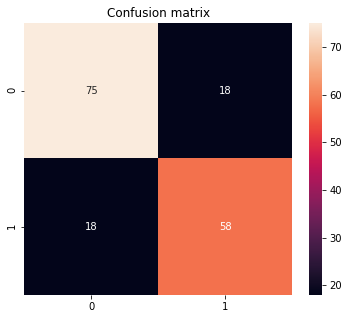

In [90]:
import sklearn.metrics as sklm
print(sklm.classification_report(y_test_clf, y_pred_grid_rf))

conf = pd.DataFrame(sklm.confusion_matrix(y_test_clf, y_pred_grid_rf))

plt.figure(figsize=(6, 5))
plt.title('Confusion matrix')
sns.heatmap(conf, annot=True, fmt='d'); 

### GradientBoostingClassifier

In [91]:
from sklearn.ensemble import GradientBoostingClassifier

GB = GradientBoostingClassifier()
gb_params = {
    'loss': ["deviance"],
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.05, 0.01],
    'max_depth': [4, 6, 8],
    'min_samples_leaf': [100, 150],
    'max_features': [0.3, 0.2, 0.1]
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}


gb_grid = GridSearchCV(GB,
                       param_grid=gb_params,
                       cv=4,
                       scoring=scorers,
                       refit='accuracy_score',
                       n_jobs=-1,
                       verbose=1)


gb_grid.fit(X_train_clf, y_train_clf)

Fitting 4 folds for each of 162 candidates, totalling 648 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed:   13.8s finished


GridSearchCV(cv=4, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_c...
                 

In [92]:
y_pred_gb = gb_grid.predict(X_test_clf)
best_GB = gb_grid.best_estimator_

              precision    recall  f1-score   support

           0       0.72      0.77      0.75        93
           1       0.70      0.63      0.66        76

    accuracy                           0.71       169
   macro avg       0.71      0.70      0.70       169
weighted avg       0.71      0.71      0.71       169



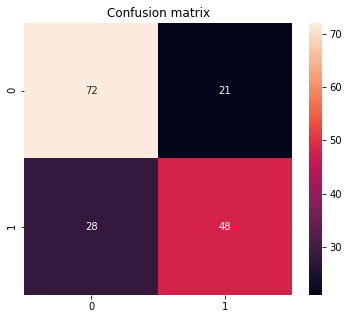

In [93]:
import sklearn.metrics as sklm
print(sklm.classification_report(y_test_clf, y_pred_gb))

conf = pd.DataFrame(sklm.confusion_matrix(y_test_clf, y_pred_gb))

plt.figure(figsize=(6, 5))
plt.title('Confusion matrix')
sns.heatmap(conf, annot=True, fmt='d');

Here gradient boosting does very poorly, comparatively to all other models. We wont keep it for the ensembling.

### Learning curves

Determines cross-validated training and test scores for different training set sizes

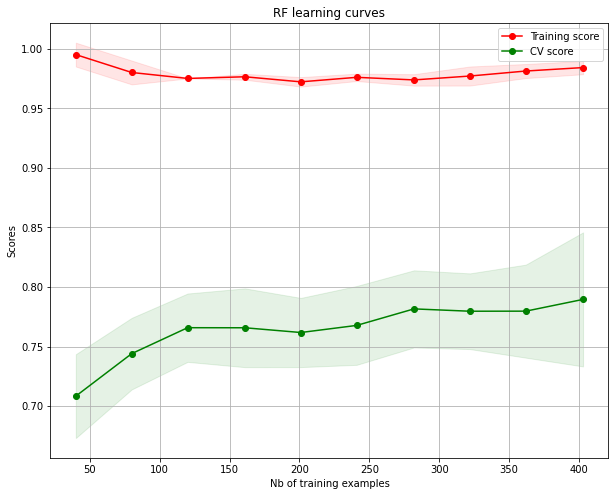

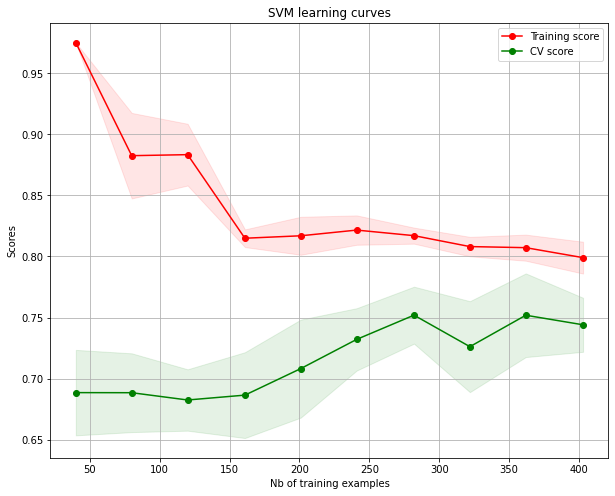

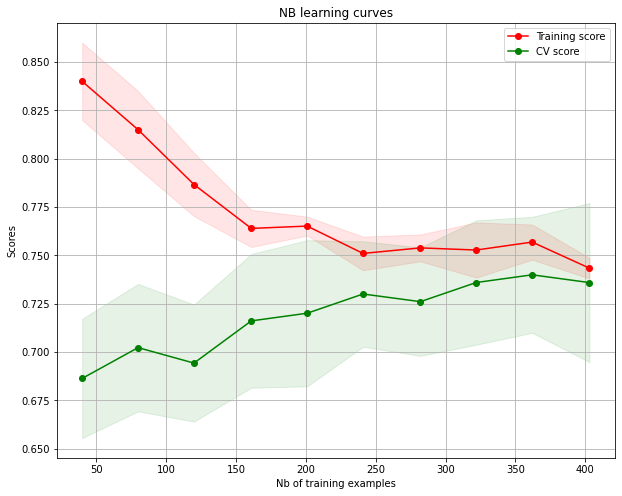

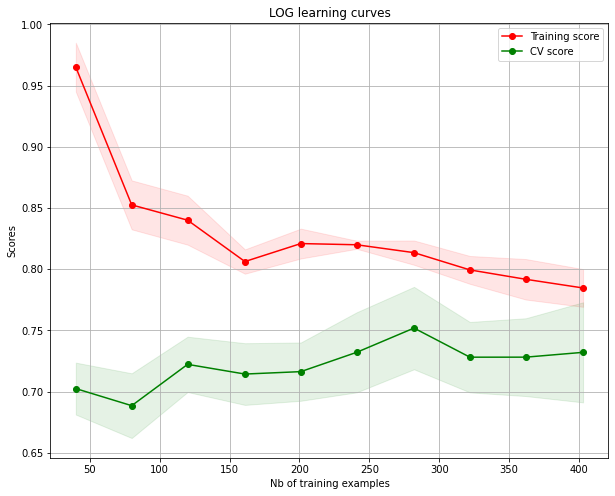

In [94]:
from sklearn.model_selection import learning_curve


def plot_learning_curve(estimator, title,
                        X, y, ylim=None, cv=None,
                        n_jobs=-1,
                        train_sizes=np.linspace(.1, 1.0, 10)):
    """Generate the learning curves of the given estimator"""

    plt.figure(figsize=(10, 8))
    plt.title(title)

    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Nb of training examples")
    plt.ylabel("Scores")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes,
                     train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std,
                     alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes,
                     test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std,
                     alpha=0.1,
                     color="g")
    plt.plot(train_sizes,
             train_scores_mean,
             'o-',
             color="r",
             label="Training score")
    plt.plot(train_sizes,
             test_scores_mean,
             'o-',
             color="g",
             label="CV score")

    plt.legend(loc="best")
    return plt


g = plot_learning_curve(best_rf, "RF learning curves",
                        X_train_clf, y_train_clf, cv=5)
g = plot_learning_curve(svc_best, "SVM learning curves",
                        X_train_clf, y_train_clf, cv=5)
g = plot_learning_curve(best_gs, "NB learning curves",
                        X_train_clf, y_train_clf, cv=5)
g = plot_learning_curve(best_lr, "LOG learning curves",
                        X_train_clf, y_train_clf, cv=5)

## Now is time to ensemble our favorite models

Here we take into account two parameters : the model single performance and also the way it finds pattern in the data (i.e. we want some tree based and some linear models)

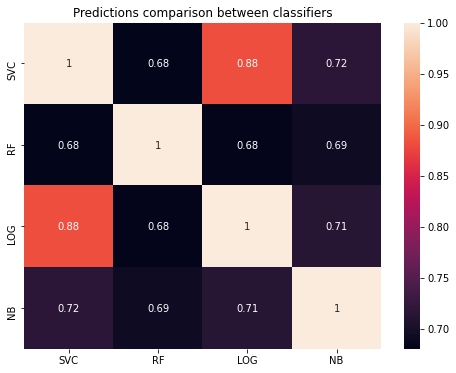

In [131]:
SVC = pd.Series(svc_best.predict(X_test_clf), name="SVC")
RF = pd.Series(best_rf.predict(X_test_clf), name="RF")
LOG = pd.Series(best_lr.predict(X_test_clf), name="LOG")
NB = pd.Series(best_gs.predict(X_test_clf), name="NB")

ensemble_res = pd.concat([
    SVC, RF, LOG,
    NB
],
    axis=1)

plt.figure(figsize=(8, 6))
plt.title('Predictions comparison between classifiers')
g = sns.heatmap(ensemble_res.corr(), annot=True)


Predictions are very close between SVM, logistic regression, both being linear classifier. RF and gaussian NB are a falling behind. But they seem to be bringing some differences in the predictions wich may be good for ensembling.

Theses differences between the classifiers predictions are sufficient to consider an ensembling vote. Here, we choose both logitic regression and SVM, while keeping Naive bayes model for it's singularity.

In [132]:
from sklearn.ensemble import StackingClassifier, VotingClassifier


SVC = pd.Series(svc_best.predict(X_test_clf), name="SVC")
RF = pd.Series(best_rf.predict(X_test_clf), name="RF")
LOG = pd.Series(best_lr.predict(X_test_clf), name="LOG")
NB = pd.Series(best_gs.predict(X_test_clf), name="NB")

ensemble_vot = StackingClassifier([('SVC', svc_best),
                                   ('LOG', best_lr), ('NB', best_gs)],
                                  n_jobs=-1)

ensemble_vot = ensemble_vot.fit(X_train_clf, y_train_clf)

In [133]:
y_pred_ens = ensemble_vot.predict(X_test_clf)

              precision    recall  f1-score   support

           0       0.85      0.81      0.83        93
           1       0.78      0.83      0.80        76

    accuracy                           0.82       169
   macro avg       0.82      0.82      0.82       169
weighted avg       0.82      0.82      0.82       169



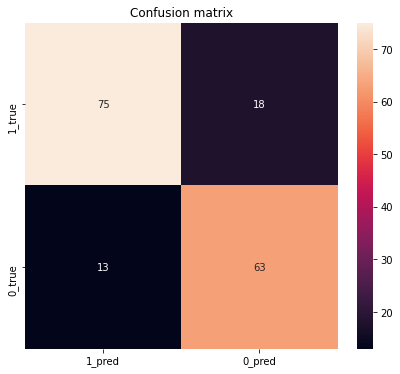

In [134]:
print(sklm.classification_report(y_test_clf, y_pred_ens))

conf = pd.DataFrame(sklm.confusion_matrix(y_test_clf, y_pred_ens), index=[
                    '1_true', '0_true'], columns=['1_pred', '0_pred'])

plt.figure(figsize=(7, 6))
plt.title('Confusion matrix')
sns.heatmap(conf, annot=True, fmt='d');

Ensembling allow us to improve our baseline classifiers by a confortable margin, we still have some trouble predicting high salaries. Maybe we should consider investigating outliers more. 

More features may be the key to a more accurate model, especially features helping the model predict higher salaries. We could also investigate more complex models and ensembling methods, but considering the noise inherent to scraped data it will never reach a perfect accuracy.

Finally, we note that features engineering should be different depending if we want to fit a tree based or a linear model.

As a side note, we could also make more use of pipelines to shorten and improve the code.

In [135]:
filename = 'ensembled_clf.sav'
pickle.dump(ensemble_vot, open(filename, 'wb'))